# Set up

Python librairies imports :

In [125]:
# File system management
import os

import pickle

# Data manipulation
import numpy as np
import pandas as pd

# Data algoritms
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 

# Hyperparameters optimisation
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
from hyperopt.pyll.base import scope

from imblearn.over_sampling import SMOTE

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(palette="Set1")

Define work location :

In [2]:
project_path = "/Users/victor/Documents/OPENCLASSROOMS/projet_7"

# Change directory
os.chdir(project_path)

Load data :

In [3]:
# Load data
data = pd.read_csv("data/processed/train_feature_engineering.csv", index_col=[0])

# Functions

In [25]:
# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [93]:
# Function to compute roc curve
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=False):
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:
        # Compute best threshold
        o_tpr = tpr[np.argmin(np.abs(fpr+tpr-1))]
        o_fpr = fpr[np.argmin(np.abs(fpr+tpr-1))]
        o_threshold = thresholds[np.argmin(np.abs(fpr+tpr-1))]

        # Display best threshold
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold = {:.3f}".format(o_threshold))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # Return AUC score
    return auc

# MLFlow

Set up of MLFlow tracking.

In [4]:
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Create experiment
experiment_name = 'credit_scoring'
mlflow.set_experiment(experiment_name)
mlflow.end_run()

file:///Users/victor/Documents/OPENCLASSROOMS/projet_7/mlruns/982388865821309393/ebdf1778e20441f1a9e20b35b3028b2f/artifacts
file:///Users/victor/Documents/OPENCLASSROOMS/projet_7/mlruns


In [41]:
# Function to log model to mlflow
def log_mlflow(model, model_name, model_auc, model_f1, model_acc):

    # Track params and metrics 
    with mlflow.start_run():
        mlflow.set_tag("model_name", model_name)
        mlflow.log_metric("AUC", model_auc)
        mlflow.log_metric("F1", model_f1)
        mlflow.log_metric("Accuracy", model_acc)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, model_name)

    mlflow.end_run()

# Data preparation

In [6]:
# Define target and features
TARGET = 'TARGET'
target = data[TARGET].to_numpy()
features = data.drop(columns=TARGET).to_numpy()
features_names = data.drop(columns=TARGET).columns.to_list()

In [7]:
# Check percentage of missing values
print(data.isna().sum().sum()/data.size*100)

# Check class weights
display(data[TARGET].value_counts())

23.70605835194158


Fill missing values with simple imputer.

In [8]:
# Create imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit to data
imp_mean.fit(features)

# Transform data
features_imp = imp_mean.transform(features)

@TODO: scaledata ? without encoded columns

In [45]:
# Define training set size
TRAIN_SIZE = 0.8

# Define random state
RANDOM_STATE = 42

Split the data into training and testing sets.

In [10]:
# Split dataset
x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)
x_train_imp, x_test_imp, y_train, y_test = train_test_split(features_imp, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

In [51]:
# Define stratifiedKfold
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
# # Balance data
# sm_data_x, sm_data_y = SMOTE(random_state=0).fit_resample(x_train, y_train)
# sm_data_x = pd.DataFrame(data=sm_data_x, columns=features_names.columns)
# sm_data_y = pd.DataFrame(data=sm_data_y, columns=[TARGET])

# # Check balanced data
# print("length of oversampled data is ",len(sm_data_x))
# print("Number of no subscription in oversampled data",len(sm_data_y[sm_data_y[TARGET]==1]))
# print("Number of subscription",len(sm_data_y[sm_data_y[TARGET]==0]))
# print("Proportion of no subscription data in oversampled data is ",len(sm_data_y[sm_data_y[TARGET]==1])/len(sm_data_x))
# print("Proportion of subscription data in oversampled data is ",len(sm_data_y[sm_data_y[TARGET]==0])/len(sm_data_x))

# Classification

- dummies? regression poly?
- randomforest
- xgboost
- lightGBM

In [95]:
# Define threshold
THRESHOLD_CLASS0 = 0.7  # belong to class 0 (repay success)
THRESHOLD_CLASS1 = 1 - THRESHOLD_CLASS0  # belong to class 1 (repay failure)

## LogisticRegression

In [62]:
# Create logistic regression model
lr = LogisticRegression(random_state=RANDOM_STATE)
lr_name = 'LogisticRegression'

In [96]:
# Fit model to data
lr.fit(x_train_imp, y_train)

# Predict probability of class 1 (repay failure)
lr_pred_proba = lr.predict_proba(x_test_imp)[:,1]

# Predict values with custom threshold
lr_pred = (lr_pred_proba >= THRESHOLD_CLASS1).astype('int')

/Users/victor/miniconda3/envs/oc_p7/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


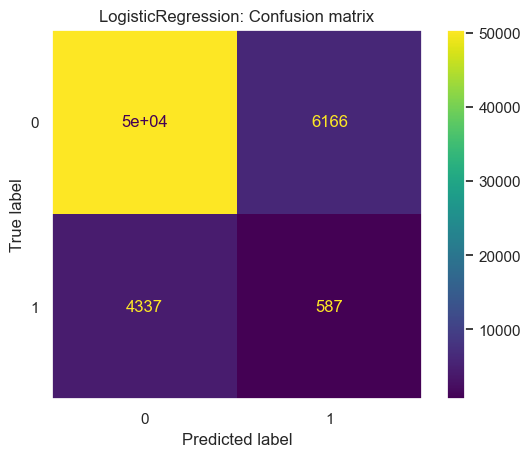

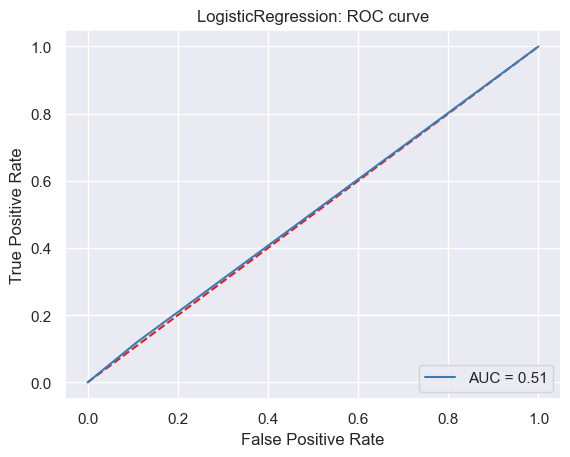

F1 score =  0.10053952213753534
Acccuracy =  0.829225065851517


In [97]:
# Display confusion matrix
display_confusion_matrix(y_test, lr_pred, model_name=lr_name)

# Draw roc curve
lr_auc = compute_roc_curve(y_test, lr_pred, model_name=lr_name)

# Compute f1 score
lr_f1 = f1_score(y_test, lr_pred)
lr_acc = accuracy_score(y_test, lr_pred)
print("F1 score = ", lr_f1)
print("Acccuracy = ", lr_acc)

In [31]:
# Log mlflow
log_mlflow(model=lr, model_name=lr_name, model_auc=lr_auc, model_f1=lr_f1, model_acc=lr_acc)

## RandomForest

In [35]:
# Create random forest classifier
rf = RandomForestClassifier(max_depth=2, random_state=RANDOM_STATE)
rf_name = 'RandomForest'

In [106]:
# Fit model to data
rf.fit(x_train_imp, y_train)

# Predict probability of class 1 (repay failure)
rf_pred_proba = rf.predict_proba(x_test_imp)[:,1]

# Predict values with custom threshold
rf_pred = (rf_pred_proba >= THRESHOLD_CLASS1).astype('int')

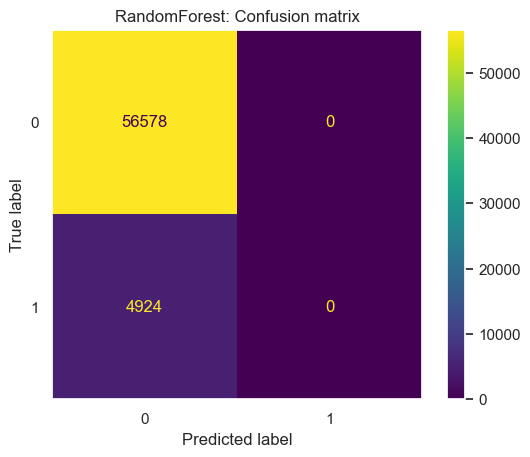

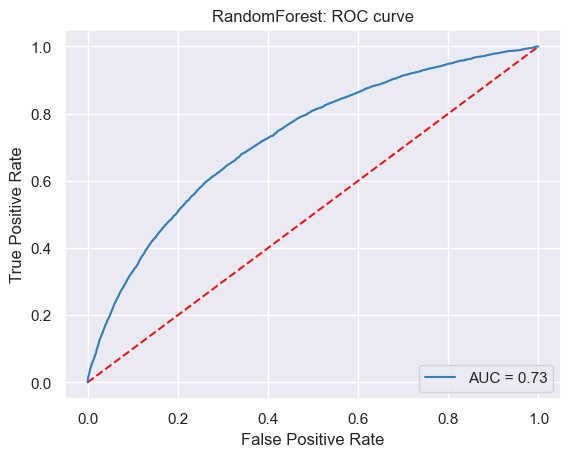

F1 score =  0.0
Acccuracy =  0.9199375630060811


In [107]:
# Display confusion matrix
display_confusion_matrix(y_test, rf_pred, model_name=rf_name)

# Draw roc curve
rf_auc = compute_roc_curve(y_test, rf_pred_proba, model_name=rf_name)

# Compute scores
rf_f1 = f1_score(y_test, rf_pred)
rf_acc = accuracy_score(y_test, rf_pred)
print("F1 score = ", rf_f1)
print("Acccuracy = ", rf_acc)

In [44]:
# Log mlflow
log_mlflow(model=rf, model_name=rf_name, model_auc=rf_auc, model_f1=rf_f1, model_acc=rf_acc)

In [126]:
# Save model
filename = 'models/randomforest_v1.pckl'
pickle.dump(rf, open(filename, 'wb'))

## Hyperopt

In [122]:
# possible values of parameters
space = {"n_estimators": hp.choice("n_estimators", [100, 200, 300, 400,500,600]),
         "max_depth": scope.int(hp.quniform('max_depth', 1, 15, q=1)),
         "criterion": hp.choice("criterion", ["gini", "entropy"]),
}

In [119]:
# define objective function
def hyperparameter_tuning(params):
    clf = RandomForestClassifier(**params,n_jobs=-1)
    acc = cross_val_score(clf, x_train_imp, y_train, scoring="accuracy").mean()
    return {"loss": -acc, "status": STATUS_OK}

In [ ]:
# Initialize trials object
trials = Trials()

best = fmin(
    fn=hyperparameter_tuning,
    space = space, 
    algo=tpe.suggest, 
    max_evals=10, 
    trials=trials
)

print("Best: {}".format(best))